# OSCAR NRCS Calibration
### Generates incidence angle dependent NRCS calibration curves as an azimuth-averaged difference between OSCAR observations and NSCAT-4DS

In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import seastar as ss
import pandas as pd
import warnings
import os
from _version import __version__
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from _version import __version__
from datetime import datetime
from scipy.optimize import curve_fit
import matplotlib as mpl
from seastar.utils.tools import db2lin as db2lin
from seastar.utils.tools import lin2db as lin2db
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from time import time
import matplotlib.path as mpltPath
from scipy import interpolate
def iqr(da, dim):
    """Calculates interquartile range"""
    return (da.quantile(q=0.75, dim=dim) - da.quantile(q=0.25, dim=dim)).rename("iqr")
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def fit_func_simple(az, A, B, C, f):
    g = A * (
            1\
            + np.sign(A)*B*np.cos(np.radians(az-f))\
            + np.sign(A)*C*np.cos(np.radians(2*(az-f)))
        )
    return(g.ravel())
def fit_func_simple2(az, A, B, C, f):
    g = A   + B*np.cos(np.radians(az-f))\
            + C*np.cos(np.radians(2*(az-f))
        )
    return(g.ravel())

def star_pattern_analysis(ds_L1c, vars_list, coords_list, tracks, u10, updir, 
                           exclude_tracks = False, tracks_to_exclude = [None],
                         ):
    exclude_tracks = False
    track_names_list = ['Track_' + str(track) for track in tracks]
    dsl2 = [None] * len(track_names_list)
    for ii, track in enumerate(track_names_list):
        dsl2[ii] = ds_L1c[track][vars_list + coords_list]
    # check to see what interp_like changes, make sure there is no funny business 
    for ii in range(1,len(dsl2)):
        dsl2[ii] = dsl2[ii].interp_like(dsl2[0])
    L1 = xr.concat(dsl2, dim='Track')
    L1['Track'] = tracks
    del dsl2
    med = L1.sel(Track=tracks)[vars_list + coords_list].median(dim='CrossRange')
    med = med.set_coords(coords_list)
    
    inci_bins = np.arange(20.5, 71.5, 1)
    inci_center = np.arange(21, 71, 1)
#     var_list = ['Sigma0', 'Interferogram','Coherence','RadialSurfaceVelocity'] # ADD TO FUNCTIONS VARIABLES
    var_list = list(set(vars_list) & set(['Sigma0', 'Interferogram','Coherence','RadialSurfaceVelocity']))
    data = dict()
    azimuth = np.zeros((med.Track.size, med.Antenna.size))
    for var in var_list:
        data[var] = np.ones((med.Track.size, med.Antenna.size, len(inci_center)))
        for itrack, track in enumerate(med.Track.data):
            for iantenna, antenna in enumerate(med.Antenna.data):
                azimuth[itrack, iantenna] = med.AntennaAzimuthImage.sel(Track=track, Antenna=antenna).mean().data
                data[var][itrack, iantenna, :] = med[var].sel(Track=track, Antenna=antenna)\
                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
    nds = dict()
#     var_list = ['Sigma0', 'Interferogram','Coherence','RadialSurfaceVelocity']
    for var in var_list:
        nds[var] = xr.Dataset({var: (["Track", "Antenna", "inci"], data[var] )},
                           coords={"azimuth": (["Track", "Antenna"], azimuth),
                                   "inci": (["inci"], inci_center),
                                   "Track": (["Track"], med.Track.data),
                                   "Antenna": (["Antenna"], med.Antenna.data),
                                  }
                           )
    if 'Sigma0' in data.keys():
        nds['Sigma0'] = 10*np.log10(nds['Sigma0'])
    nds = xr.merge([nds[var] for var in nds.keys()], compat='no_conflicts', join='outer')    
    inci_joint = np.arange(25,66)
    az = np.arange(0,360)
    ones = np.ones(np.size(az))
    nb_parameters = 4
    popt = dict()
    for var in var_list:
        popt[var] = np.zeros((med.Antenna.size, len(inci_joint), nb_parameters))
    p0 = [1,1,1,1]
    for var in var_list:
        for iantenna, antenna in enumerate(med.Antenna):
            for ii, inci_value in enumerate(inci_joint):
                lds = nds.sel(Antenna=antenna, inci=inci_value)
                if var == 'Sigma0':
                    if not np.isnan(lds.Sigma0.data.ravel()).all():
                        valid = ~np.isnan(lds.Sigma0.data.ravel())
                        if exclude_tracks:
                            for i in tracks_to_exclude:
                                valid[i-1] = False
                        p0, pcov = curve_fit(fit_func_simple,
                                             az,
                        10*np.log10(ss.gmfs.nrcs.nscat4ds(u10*ones,
                                                          np.abs(np.mod(az - updir +180, 360) - 180),
                                                          inci_value*ones,
                                                          ones)),
                                            )
                        popt['Sigma0'][iantenna, ii, :], pcov = curve_fit( 
                            fit_func_simple, lds.azimuth.data.ravel()[valid], lds.Sigma0.data.ravel()[valid],
                            check_finite=True, 
                            p0=p0, 
    #                         bounds=([-50, 0, 0, 0], [+10, 1, 1, 360])
                        )
                else:
                    if not antenna.data[()] == 'Mid':
                        valid = ~np.isnan(lds[var].data.ravel())
                        if exclude_tracks:
                            for i in tracks_to_exclude:
                                valid[i-1] = False
                        if var == 'Interferogram':
                            popt[var][iantenna, ii, :], pcov = curve_fit(
                                fit_func_simple2, lds.azimuth.data.ravel()[valid], lds[var].data.ravel()[valid],
                            maxfev = 100000)
                        else:
                            popt[var][iantenna, ii, :], pcov = curve_fit(
                                fit_func_simple, lds.azimuth.data.ravel()[valid], lds[var].data.ravel()[valid],p0 = p0,
                                maxfev = 100000)
                            p0 = popt[var][iantenna,ii]
    fit = dict()
    for var in var_list:
        fit[var] = xr.Dataset({var: (["Antenna", "inci", "parameters"], popt[var])},
                           coords={"parameters": (["parameters"], ["A", "B", "C", "f"]),
                               "inci": (["inci"], inci_joint),
                               "Antenna": (["Antenna"], med.Antenna.data)})
    fit = xr.merge([fit[var] for var in fit.keys()], compat='no_conflicts', join='outer')
    return nds, fit
def compute_land_mask_from_GSHHS(da, skip):

    boundary = [np.min(da.longitude.data),
                np.max(da.longitude.data),
                np.min(da.latitude.data),
                np.max(da.latitude.data)]
    lon_skip, lat_skip = np.meshgrid(np.arange(boundary[0], boundary[1], skip),
                                     np.arange(boundary[2], boundary[3], skip))
    
    coast_polygons = dict()
    m, n = lon_skip.shape
    mask = np.full((m, n), False).ravel()
    print('Scanning GSHHS dataset for coastlines within boundary...')
    coast = cfeature.GSHHSFeature(scale='full').intersecting_geometries(boundary)
    for k, polygon in enumerate(coast):
        coast_polygons[k] = polygon
    
    xy = coast_polygons[0].exterior.coords.xy
    
    start_time = time()
    path = mpltPath.Path(np.array([np.array(xy).T[:,0],np.array(xy).T[:,1]]).T)
    inside = path.contains_points(np.array([list(lon_skip.ravel()),list(lat_skip.ravel())]).T)
    print("Elapsed time: " + str(time()-start_time))
    
    mask = xr.DataArray(
        data=interpolate.griddata(
            points=(np.ravel(lon_skip),
                    np.ravel(lat_skip)),
            values=(np.ravel(inside)),
            xi=(da.longitude.values,
                da.latitude.values),
            method='nearest'
        ),
        dims=da.dims,
        coords=da.coords
    )
    return mask

# Load OSCAR data

In [23]:
# version = 'v20250318'
version = 'v20250306'
file_paths = dict()
# file_paths = ss.utils.readers._set_file_paths()
# file_paths['l1c_path'] = os.path.join(r'C:\data\seastarex\SEASTARex\Data\L1c\window7','')
# file_paths['l1b_path'] = os.path.join(r'C:\data\seastarex\SEASTARex\Data\L1b',version,'')
# file_paths['l1b_path'] = os.path.join(r'D:\data\OSCAR\L1b','')
# L1c_path = os.path.join(file_paths['l1c_path'],'')
DAR_tracks = dict()
DAR_tracks['20220522'] = {
    'Track_11': 3,
    'Track_12': 4,
    'Track_13': 5,
    'Track_14': 6,
    'Track_15': 7,
    'Track_16': 8,
    'Track_17': 9,
    'Track_18': 10,
}
DAR_tracks['20230508'] = {
    'Track_1': 1,
    'Track_2': 2,
    'Track_3': 3,
    'Track_4': 4,
    'Track_5': 5,
    'Track_6': 6,
    'Track_7': 7,
    'Track_8': 8,
    'Track_9': 9,
    'Track_10': 10,
#     'Track_11': 11,
#     'Track_12': 12,
#     'Track_13': 13,
#     'Track_14': 14,
}


# flight = '20220522'
flight = '20230508'
# version = 'v20250601_new'
file_paths = ss.utils.readers._read_config(config_file='config_LIVPC141.ini')
file_paths['l1c_path'] = os.path.join(r'C:\data\seastarex\SEASTARex-Med\L1c','')
file_paths['l1b_path'] = os.path.join(r'C:\data\seastarex\SEASTARex-Med\L1b',version,'')
# file_paths['l1b_path'] = os.path.join(r'D:\data\OSCAR\L1b',version,'')
# L1c_path = os.path.join(file_paths['l1c_path'],'')
reduce_track_length = True
load_L1b = True

if load_L1b:
    ds_L1b = dict()
ds_L1c = dict()

for track in DAR_tracks[flight].keys():
    print('Processing track',track,'...')
    if load_L1b:
        ds_L1c[track] = xr.open_dataset(file_paths['l1b_path'] + flight + '_' + track + '_OSCAR_L1b.nc')
        rsv = [ss.oscar.level1.compute_radial_surface_velocity(ds_L1c[track].sel(Antenna=ant))
               for ant in ds_L1c[track].Antenna.values]
        ds_L1c[track]['RadialSurfaceVelocity'] = xr.concat(rsv, 'Antenna',join='outer')
        ds_L1c[track]['Sigma0'] = ds_L1c[track].Intensity.copy()
    else:
        ds_L1c[track] = xr.open_dataset(file_paths['l1c_path'] + flight + '_' + track + '_OSCAR_L1c.nc')
    if reduce_track_length:
        track_length = len(ds_L1c[track].CrossRange)
        ds_L1c[track] = ds_L1c[track].sel(
            CrossRange = ds_L1c[track].CrossRange[int(track_length / 2) - 400 : int(track_length / 2 + 400)]
        )
print('...Done')

Device name = LIVPC141
Setting local paths...
Processing track Track_1 ...
Processing track Track_2 ...
Processing track Track_3 ...
Processing track Track_4 ...
Processing track Track_5 ...
Processing track Track_6 ...
Processing track Track_7 ...
Processing track Track_8 ...
Processing track Track_9 ...
Processing track Track_10 ...
...Done


# Land phase Calibration

In [17]:
land_track = 'Track_L1'
flight +'_OSCAR_' + 'LandCalib_' + 'Tracks' + land_track.replace('Track_','') + '_' + version + '.nc'

'20220522_OSCAR_LandCalib_TracksL1_v20250318.nc'

In [24]:
land_track = 'Track_L1'

ds_L1b_land = xr.open_dataset(os.path.join(file_paths['l1b_path'], flight + '_' + land_track + '_OSCAR_L1b.nc'))
mask_mid = compute_land_mask_from_GSHHS(ds_L1b_land.Interferogram.sel(Antenna='Mid'),skip=1/250)
mask_fore = compute_land_mask_from_GSHHS(ds_L1b_land.Interferogram.sel(Antenna='Fore'),skip=1/1000)
mask_aft = compute_land_mask_from_GSHHS(ds_L1b_land.Interferogram.sel(Antenna='Aft'),skip=1/1000)
ds_L1b_land['LandMask'] = xr.concat([mask_mid, mask_fore, mask_aft],'Antenna',join='outer')

# phase = [ds_L1b_land.sel(Antenna='Fore').Interferogram.where(mask_fore==1).median(dim='CrossRange'),
#           ds_L1b_land.sel(Antenna='Aft').Interferogram.where(mask_aft==1).median(dim='CrossRange')]
# incidence_angle = [ds_L1b_land.sel(Antenna='Fore').IncidenceAngleImage.where(mask_fore==1).median(dim='CrossRange'),
#                    ds_L1b_land.sel(Antenna='Aft').IncidenceAngleImage.where(mask_aft==1).median(dim='CrossRange')]
# phase = xr.concat(phase, dim='Antenna')
phase = ds_L1b_land.Interferogram.where(ds_L1b_land.LandMask==1).median(dim='CrossRange')
incidence_angle = ds_L1b_land.IncidenceAngleImage.where(ds_L1b_land.LandMask==1).median(dim='CrossRange')

incidence_angle = xr.concat(incidence_angle, dim='Antenna')
ds_phase = xr.merge([phase, incidence_angle])




ds_LandCalib = xr.Dataset()
ds_LandCalib['Interferogram'] = xr.concat([xr.DataArray(
    data=ds_phase.sel(Antenna=['Fore']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                       xr.DataArray(
    data=np.zeros(ds_phase.sel(Antenna=['Fore']).Interferogram.data.size),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                       xr.DataArray(
    data=ds_phase.sel(Antenna=['Aft']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                      ],pd.Index(['Fore', 'Mid','Aft'], name="Antenna"))
ds_LandCalib['Antenna'].attrs['long_name']  = 'Antenna'
ds_LandCalib['Antenna'].attrs['units']  = ''
ds_LandCalib['Antenna'].attrs['description']  = 'Name of OSCAR antenna location'
ds_LandCalib['IncidenceAngle'].attrs['long_name'] = 'Incidence angle'
ds_LandCalib['IncidenceAngle'].attrs['units'] = 'deg'
ds_LandCalib['IncidenceAngle'].attrs['description'] = 'Incidence angle between nadir and the ground'
ds_LandCalib['Interferogram'].attrs['long_name'] = 'Interferogram bias'
ds_LandCalib['Interferogram'].attrs['units'] = 'rad'
ds_LandCalib['Interferogram'].attrs['description'] = 'OSCAR Interferogram bias computed using over land data'

# tracks_used = [x.replace('Track_','') for x in ds_L1c.keys()][0] + '-' + [x.replace('Track_','') for x in ds_L1c.keys()][-1]

ds_LandCalib.attrs['Codebase'] = 'seastar_project'
ds_LandCalib.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
ds_LandCalib.attrs['CodeVersion'] = __version__
ds_LandCalib.attrs['DataVersion'] = version
ds_LandCalib.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')
ds_LandCalib.attrs['TracksUsed'] = land_track

save_folder = os.path.join(r'C:\data\seastarex\SEASTARex-Med','calib',version,'')
file_name = flight +'_OSCAR_' + 'LandCalib_' + 'Tracks' + land_track.replace('Track_','') + '_' + version + '.nc'

# ds_calib.to_netcdf(os.path.join(save_folder, file_name))

print('...Done')

Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 0.018558979034423828
Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 0.2784254550933838
Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 0.28404855728149414
...Done


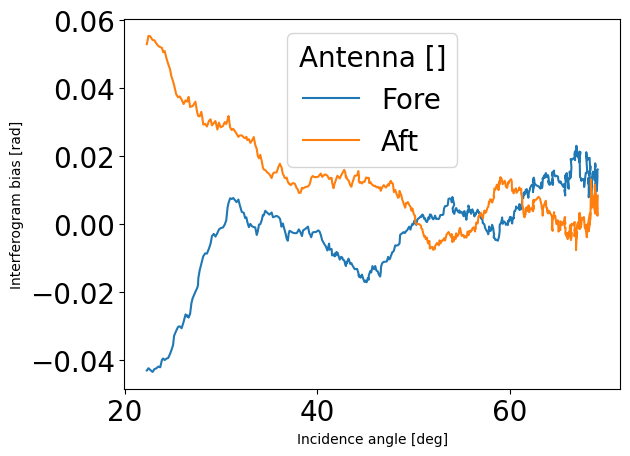

In [26]:
ds_LandCalib.sel(Antenna=['Fore','Aft']).Interferogram.plot(hue='Antenna')

# Load AROME data

In [5]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
file_paths['aux_path'] = r'C:\data\seastarex\SEASTARex\Data\Ifremer'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')

AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] = xr.open_dataset(AROME_data_folder + file)
AROME_winds = xr.concat(list(AROME_dict.values()), dim='time', join='outer')
u10 = AROME_winds.u10m.interp(time=ds_L1c['Track_11'].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1c['Track_11'].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1c['Track_11'].longitude.median(), method='nearest')
v10 = AROME_winds.v10m.interp(time=ds_L1c['Track_11'].sel(Antenna='Mid').TrackTime,method='nearest')\
        .interp(latitude=ds_L1c['Track_11'].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1c['Track_11'].longitude.median(), method='nearest')
wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
u10 = wind_speed.data
updir = wind_direction
print('...Done')

...Done


# Star-pattern analysis

In [6]:
if flight == '20230508':
    u10 = 7
    updir = 310
coords_list = ['AntennaAzimuthImage', 'IncidenceAngleImage']
vars_list = ['Sigma0', 'OrbitHeadingImage', 'SquintImage', 'Interferogram']
nds, fit = star_pattern_analysis(ds_L1c, vars_list, coords_list,
                                 tracks=[int(x.replace('Track_','')) for x in ds_L1c.keys()],
                                 u10=u10, updir=updir)
print('...Done')

...Done


# Sigma0 calibration

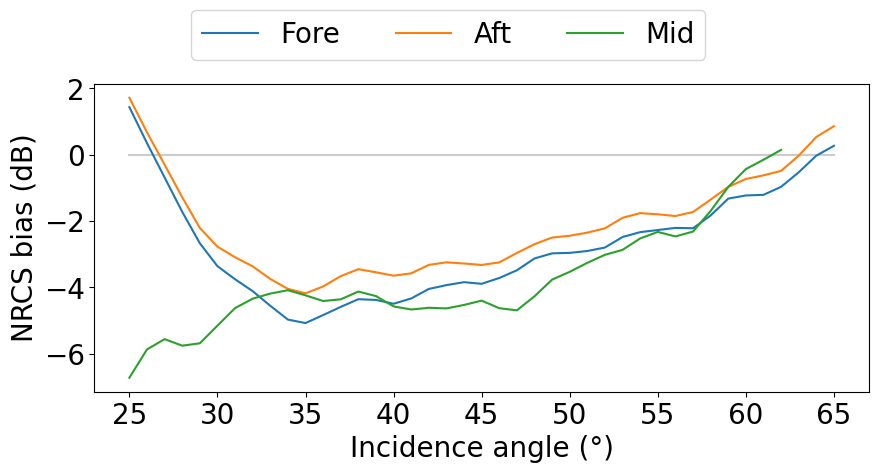

In [5]:
az = np.arange(0,360)
nscat_avg = [np.nan] * np.size(fit.inci.data)
aft_bias = [np.nan] * np.size(fit.inci.data)
mid_bias = [np.nan] * np.size(fit.inci.data)
fore_bias = [np.nan] * np.size(fit.inci.data)
aft_bias_log = [np.nan] * np.size(fit.inci.data)
fore_bias_log = [np.nan] * np.size(fit.inci.data)
mid_bias_log = [np.nan] * np.size(fit.inci.data)
for ii, inci_value in enumerate(fit.inci.data):
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(ss.gmfs.nrcs.nscat4ds(u10*ones, np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones, ones))
    nscat_avg[ii] = np.mean(nscat)
    fore_bias[ii] = np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0.data),# - nscat
        ) - db2lin(nscat_avg[ii]))
    aft_bias[ii] = np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0.data),# - nscat
        ) - db2lin(nscat_avg[ii]))
    fore_bias_log[ii] = lin2db(np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0.data)))) - nscat_avg[ii]
    aft_bias_log[ii] = lin2db(np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0.data)))) - nscat_avg[ii]  
    if inci_value <= 62:
        mid_bias[ii] = np.mean(db2lin(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0.data),# - nscat
            ) - db2lin(nscat_avg[ii]))
        mid_bias_log[ii] = lin2db(np.mean(db2lin(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0.data)))) - nscat_avg[ii] 
fore_bias = np.array(fore_bias)
aft_bias = np.array(aft_bias)
mid_bias = np.array(mid_bias)
nscat_avg = np.array(nscat_avg)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1)
plt.plot([25,65],[0,0],c=[0.8,0.8,0.8])
plt.xlabel('Incidence angle ('+u'\N{DEGREE SIGN}'+')', fontsize=20)
plt.ylabel('NRCS bias (dB)', fontsize=20)
plt.plot(fit.inci.data, fore_bias_log, color='C0',label='Fore')
plt.plot(fit.inci.data, aft_bias_log, color='C1',label='Aft')
plt.plot(fit.inci.data, mid_bias_log, color='C2',label='Mid')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=4,bbox_to_anchor=(0.75,1.1))

plt.show()

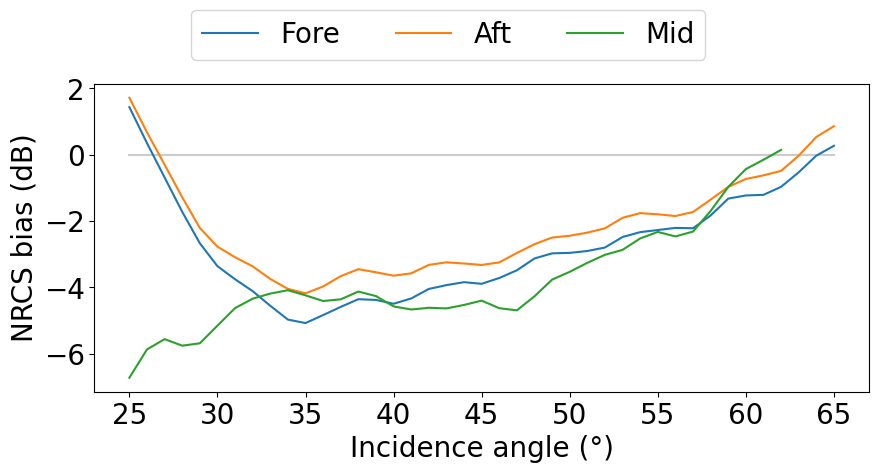

In [7]:
az = np.arange(0,360)
nscat_avg = [np.nan] * np.size(fit.inci.data)
aft_bias = [np.nan] * np.size(fit.inci.data)
mid_bias = [np.nan] * np.size(fit.inci.data)
fore_bias = [np.nan] * np.size(fit.inci.data)
aft_bias_log = [np.nan] * np.size(fit.inci.data)
fore_bias_log = [np.nan] * np.size(fit.inci.data)
mid_bias_log = [np.nan] * np.size(fit.inci.data)
for ii, inci_value in enumerate(fit.inci.data):
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(ss.gmfs.nrcs.nscat4ds(u10*ones, np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones, ones))
    nscat_avg[ii] = np.mean(nscat)
    fore_bias[ii] = np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0.data),# - nscat
        ) - db2lin(nscat_avg[ii]))
    aft_bias[ii] = np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0.data),# - nscat
        ) - db2lin(nscat_avg[ii]))
    fore_bias_log[ii] = lin2db(np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0.data)))) - nscat_avg[ii]
    aft_bias_log[ii] = lin2db(np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0.data)))) - nscat_avg[ii]  
    if inci_value <= 62:
        mid_bias[ii] = np.mean(db2lin(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0.data),# - nscat
            ) - db2lin(nscat_avg[ii]))
        mid_bias_log[ii] = lin2db(np.mean(db2lin(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0.data)))) - nscat_avg[ii] 
fore_bias = np.array(fore_bias)
aft_bias = np.array(aft_bias)
mid_bias = np.array(mid_bias)
nscat_avg = np.array(nscat_avg)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1)
plt.plot([25,65],[0,0],c=[0.8,0.8,0.8])
plt.xlabel('Incidence angle ('+u'\N{DEGREE SIGN}'+')', fontsize=20)
plt.ylabel('NRCS bias (dB)', fontsize=20)
plt.plot(fit.inci.data, fore_bias_log, color='C0',label='Fore')
plt.plot(fit.inci.data, aft_bias_log, color='C1',label='Aft')
plt.plot(fit.inci.data, mid_bias_log, color='C2',label='Mid')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=4,bbox_to_anchor=(0.75,1.1))

plt.show()

# Generate Sigma0 calibration dataset

In [8]:
ds_ocean_calib = xr.Dataset()
ds_ocean_calib['Sigma0'] = xr.concat([xr.DataArray(data=fore_bias_log, dims=["IncidenceAngle"],
                                                  coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                     xr.DataArray(data=aft_bias_log, dims=["IncidenceAngle"],
                                                  coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                     xr.DataArray(data=mid_bias_log, dims=["IncidenceAngle"],
                                                  coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                    ],pd.Index(['Fore', 'Aft', 'Mid'], name="Antenna"))

ds_ocean_calib['Interferogram'] = xr.concat([xr.DataArray(
    data=fit.sel(parameters='A', Antenna=['Fore']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                       xr.DataArray(
    data=fit.sel(parameters='A', Antenna=['Aft']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                       xr.DataArray(
    data=fit.sel(parameters='A', Antenna=['Mid']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                      ],pd.Index(['Fore', 'Aft', 'Mid'], name="Antenna"))

ds_ocean_calib['Antenna'].attrs['long_name']  = 'Antenna'
ds_ocean_calib['Antenna'].attrs['units']  = ''
ds_ocean_calib['Antenna'].attrs['description']  = 'Name of OSCAR antenna location'
ds_ocean_calib['IncidenceAngle'].attrs['long_name'] = 'Incidence angle'
ds_ocean_calib['IncidenceAngle'].attrs['units'] = 'deg'
ds_ocean_calib['IncidenceAngle'].attrs['description'] = 'Incidence angle between nadir and the ground'
ds_ocean_calib['Sigma0'].attrs['long_name'] = 'Sigma0 bias'
ds_ocean_calib['Sigma0'].attrs['units'] = 'dB'
ds_ocean_calib['Sigma0'].attrs['description'] = 'OSCAR Sigma0 bias from NSCAT-4DS computed using star pattern method'
ds_ocean_calib['Interferogram'].attrs['long_name'] = 'Interferogram bias'
ds_ocean_calib['Interferogram'].attrs['units'] = 'rad'
ds_ocean_calib['Interferogram'].attrs['description'] = 'OSCAR Interferogram bias computed using star pattern method'


ds_ocean_calib.attrs['Codebase'] = 'seastar_project'
ds_ocean_calib.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
ds_ocean_calib.attrs['Code_version'] = __version__
ds_ocean_calib.attrs['Data_version'] = version
ds_ocean_calib.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')
ds_ocean_calib

<xarray.Dataset>
Dimensions:         (IncidenceAngle: 41, Antenna: 3)
Coordinates:
  * IncidenceAngle  (IncidenceAngle) int32 25 26 27 28 29 30 ... 61 62 63 64 65
  * Antenna         (Antenna) object 'Fore' 'Aft' 'Mid'
Data variables:
    Sigma0          (Antenna, IncidenceAngle) float64 1.431 0.3473 ... nan nan
    Interferogram   (Antenna, IncidenceAngle) float64 -0.02273 -0.0147 ... 0.0
Attributes:
    Codebase:      seastar_project
    Repository:    https://github.com/NOC-EO/seastar_project
    Code_version:  2025.03.2
    Data_version:  v20250318
    Comments:      Processed on 20250320

# Save calibration dataset

In [137]:
save_folder = os.path.join(r'C:\data\seastarex\SEASTARex-Med','calib',version,'')
file_name = flight +'_OSCAR_' + 'Ocean_pattern_calib_' + 'v' + __version__ +'.nc'

ds_ocean_calib.to_netcdf(os.path.join(save_folder, file_name))

# Interferometric calibration
### - Relative phase calibration using ocean pattern
### - Land calibration after ocean pattern removal
### - Smoothing or polynomial of resulting curve

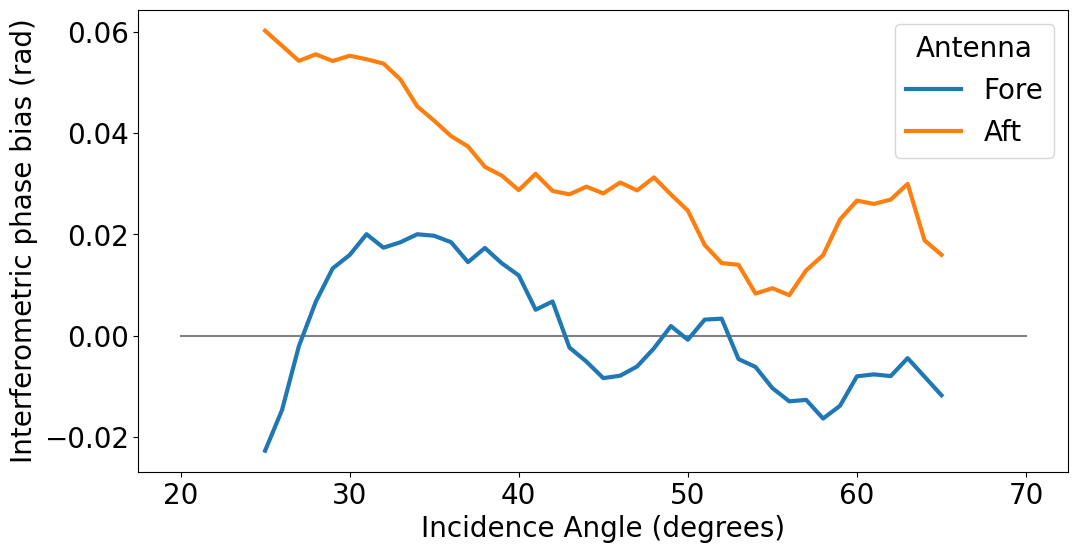

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
plt.plot([20,70],[0,0],c=[0.5,0.5,0.5])
ds_ocean_calib.Interferogram.sel(Antenna=['Fore','Aft']).plot(hue='Antenna', x='IncidenceAngle', linewidth=3)
plt.xlabel('Incidence Angle (degrees)', fontsize=20)
plt.ylabel('Interferometric phase bias (rad)', fontsize=20)
plt.show()

In [10]:
land_track = 'Track_L1'
ds_ocean_calibrated = xr.open_dataset(os.path.join(file_paths['l1b_path'],
                                                              flight + '_' + land_track + '_OSCAR_L1b.nc'))


ds_ocean_calibrated['Interferogram'] = xr.concat([ds_ocean_calibrated.Interferogram.sel(Antenna=ant) 
                           - xr.DataArray(data=np.interp(ds_ocean_calibrated.IncidenceAngleImage.sel(Antenna=ant),
                                                         ds_ocean_calib.IncidenceAngle.data,
                                                         ds_ocean_calib.Interferogram.sel(Antenna=ant).data),
                                          coords=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).coords,
                                        dims=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).dims)
                           for ant in ds_ocean_calibrated.Antenna],
                          dim='Antenna',
                          join='outer')

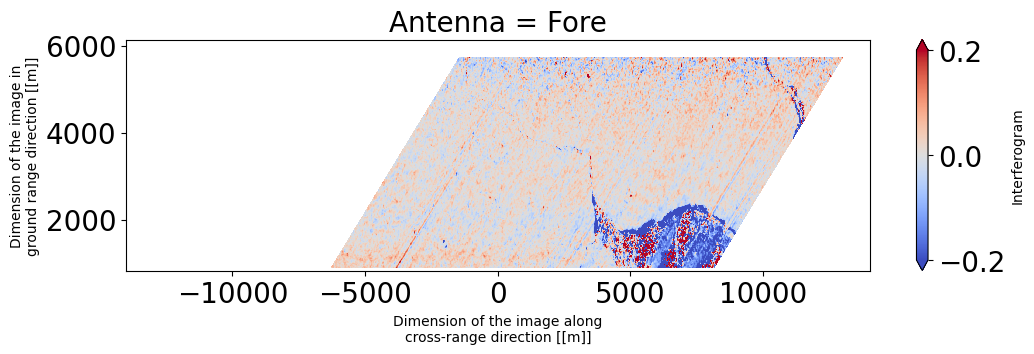

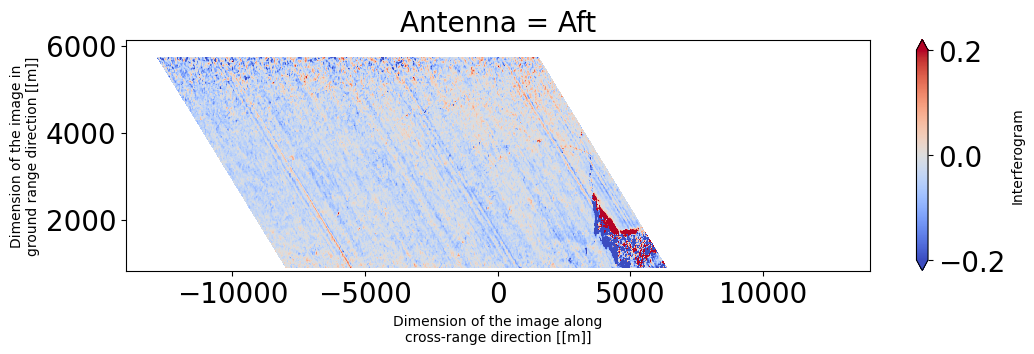

In [85]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
ds_ocean_calibrated.sel(Antenna='Fore').Interferogram.plot(x='CrossRange',y='GroundRange',
                                                           vmin=-0.2, vmax=0.2, cmap='coolwarm',)
plt.show()
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
ds_ocean_calibrated.sel(Antenna='Aft').Interferogram.plot(x='CrossRange',y='GroundRange',
                                                           vmin=-0.2, vmax=0.2, cmap='coolwarm',)
plt.show()

In [11]:

mask_mid = compute_land_mask_from_GSHHS(ds_ocean_calibrated.Interferogram.sel(Antenna='Mid'),skip=1/250)
mask_fore = compute_land_mask_from_GSHHS(ds_ocean_calibrated.Interferogram.sel(Antenna='Fore'),skip=1/1000)
mask_aft = compute_land_mask_from_GSHHS(ds_ocean_calibrated.Interferogram.sel(Antenna='Aft'),skip=1/1000)
ds_ocean_calibrated['LandMask'] = xr.concat([mask_mid, mask_fore, mask_aft],'Antenna',join='outer')

# phase = [ds_ocean_calibrated.sel(Antenna='Fore').Interferogram.where(mask_fore==1).median(dim='CrossRange'),
#           ds_ocean_calibrated.sel(Antenna='Aft').Interferogram.where(mask_aft==1).median(dim='CrossRange')]
# incidence_angle = [ds_ocean_calibrated.sel(Antenna='Fore').IncidenceAngleImage.where(mask_fore==1).median(dim='CrossRange'),
#                    ds_ocean_calibrated.sel(Antenna='Aft').IncidenceAngleImage.where(mask_aft==1).median(dim='CrossRange')]
# phase = xr.concat(phase, dim='Antenna')
phase = ds_ocean_calibrated.Interferogram.where(ds_ocean_calibrated.LandMask==1).median(dim='CrossRange')
incidence_angle = ds_ocean_calibrated.IncidenceAngleImage.where(ds_ocean_calibrated.LandMask==1).median(dim='CrossRange')

incidence_angle = xr.concat(incidence_angle, dim='Antenna')
ds_phase = xr.merge([phase, incidence_angle])




ds_LandCalib = xr.Dataset()
ds_LandCalib['Interferogram'] = xr.concat([xr.DataArray(
    data=ds_phase.sel(Antenna=['Fore']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                       xr.DataArray(
    data=np.zeros(ds_phase.sel(Antenna=['Fore']).Interferogram.data.size),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                       xr.DataArray(
    data=ds_phase.sel(Antenna=['Aft']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                      ],pd.Index(['Fore', 'Mid','Aft'], name="Antenna"))
ds_LandCalib['Antenna'].attrs['long_name']  = 'Antenna'
ds_LandCalib['Antenna'].attrs['units']  = ''
ds_LandCalib['Antenna'].attrs['description']  = 'Name of OSCAR antenna location'
ds_LandCalib['IncidenceAngle'].attrs['long_name'] = 'Incidence angle'
ds_LandCalib['IncidenceAngle'].attrs['units'] = 'deg'
ds_LandCalib['IncidenceAngle'].attrs['description'] = 'Incidence angle between nadir and the ground'
ds_LandCalib['Interferogram'].attrs['long_name'] = 'Interferogram bias'
ds_LandCalib['Interferogram'].attrs['units'] = 'rad'
ds_LandCalib['Interferogram'].attrs['description'] = 'OSCAR Interferogram bias computed using over land data'


ds_LandCalib.attrs['Codebase'] = 'seastar_project'
ds_LandCalib.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
ds_LandCalib.attrs['Code_version'] = __version__
ds_LandCalib.attrs['Data_version'] = version
ds_LandCalib.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')


save_folder = os.path.join(r'C:\data\seastarex\SEASTARex-Med','calib',version,'')
file_name = flight +'_OSCAR_' + 'Land_calib_' + 'v' + __version__ +'.nc'

# ds_calib.to_netcdf(os.path.join(save_folder, file_name))

print('...Done')

Scanning GSHHS dataset for coastlines within boundary...


Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

Elapsed time: 15.637125730514526
Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 250.15960574150085
Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 247.62657928466797
...Done


In [32]:
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Fore').Interferogram.data)
z = np.polyfit(ds_LandCalib.IncidenceAngle.data[valid], ds_LandCalib.sel(Antenna='Fore').Interferogram.data[valid], deg=4)
p_fore = np.poly1d(z)
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Aft').Interferogram.data)
z = np.polyfit(ds_LandCalib.IncidenceAngle.data[valid], ds_LandCalib.sel(Antenna='Aft').Interferogram.data[valid], deg=4)
p_aft = np.poly1d(z)

poly1d([-1.51696544e-07,  2.65133559e-05, -1.62650978e-03,  4.07485444e-02,
       -3.36284312e-01])

In [49]:
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Aft').Interferogram.data)
ds_LandCalib.IncidenceAngle.data[valid].min()

21.932824397607913

'10th degree Polynomial'

In [12]:
poly_coeff = 20
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Fore').Interferogram.data)
z = np.polyfit(ds_LandCalib.IncidenceAngle.data[valid], ds_LandCalib.sel(Antenna='Fore').Interferogram.data[valid],
               deg=poly_coeff)
p_fore = np.poly1d(z)
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Aft').Interferogram.data)
z = np.polyfit(ds_LandCalib.IncidenceAngle.data[valid], ds_LandCalib.sel(Antenna='Aft').Interferogram.data[valid],
               deg=poly_coeff)
p_aft = np.poly1d(z)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
plt.plot([20,70],[0,0],c=[0.5,0.5,0.5])


plt.plot(ds_LandCalib.IncidenceAngle.data, ds_LandCalib.sel(Antenna='Fore').Interferogram.data,
         c='C0', linewidth=3, label='Fore'
        )
plt.plot(ds_LandCalib.IncidenceAngle.data, ds_LandCalib.sel(Antenna='Aft').Interferogram.data,
         c='C1', linewidth=3, label='Aft'
        )

xp = np.arange(22,70)
plt.plot(xp, p_fore(xp), c='C0', label=str(poly_coeff) + 'th degree Polynomial Fore')
plt.plot(xp, p_aft(xp), c='C1', label=str(poly_coeff) + 'th degree Polynomial Aft')

plt.plot(ds_LandCalib.IncidenceAngle.data,
         p_fore(ds_LandCalib.IncidenceAngle.data) - ds_LandCalib.sel(Antenna='Fore').Interferogram.data,
         c='C0', linestyle=':', label='Residual Fore'
        )
plt.plot(ds_LandCalib.IncidenceAngle.data,
         p_aft(ds_LandCalib.IncidenceAngle.data) - ds_LandCalib.sel(Antenna='Aft').Interferogram.data,
         c='C1', linestyle=':', label='Residual Fore'
        )



plt.xlabel('Incidence Angle (degrees)', fontsize=20)
plt.ylabel('Interferometric phase bias (rad)', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3,bbox_to_anchor=(0.94,1.1))

plt.show()




NameError: name 'ds_LandCalib' is not defined

C:\Users\dmca\AppData\Local\Temp\ipykernel_41380\1793321567.py:7: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(incidence_angle[valid],


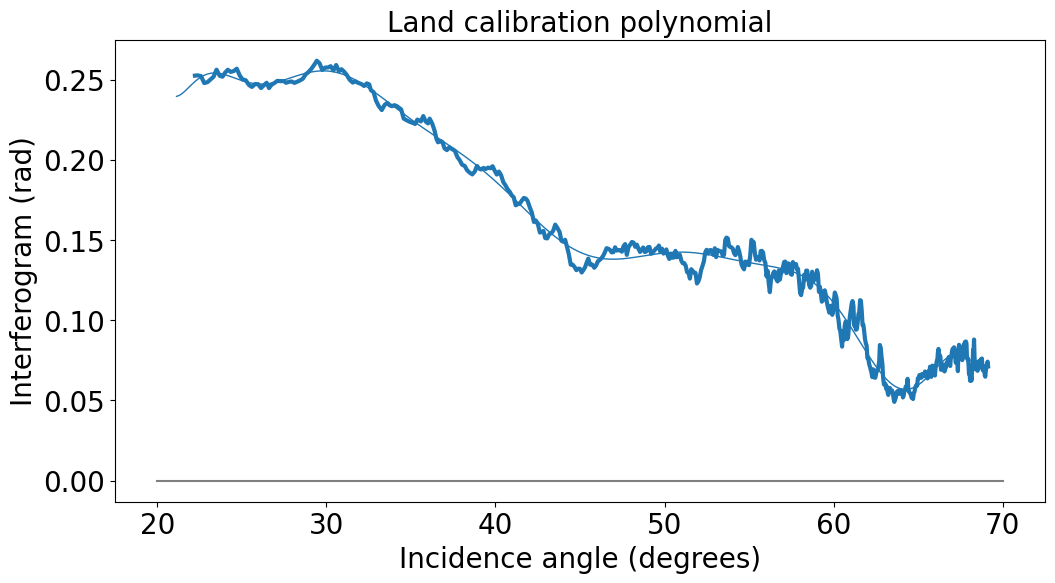

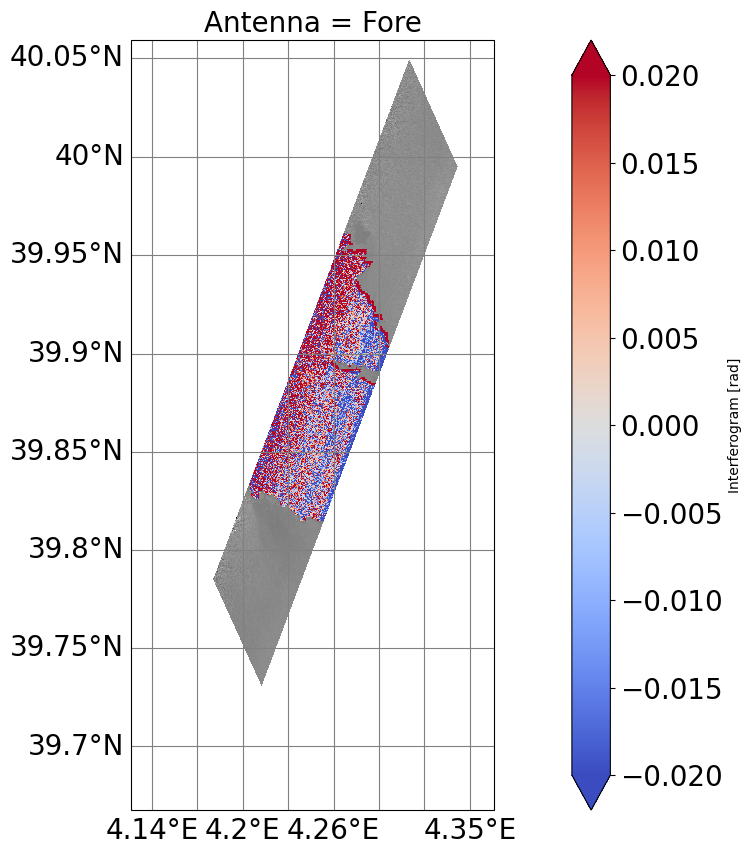

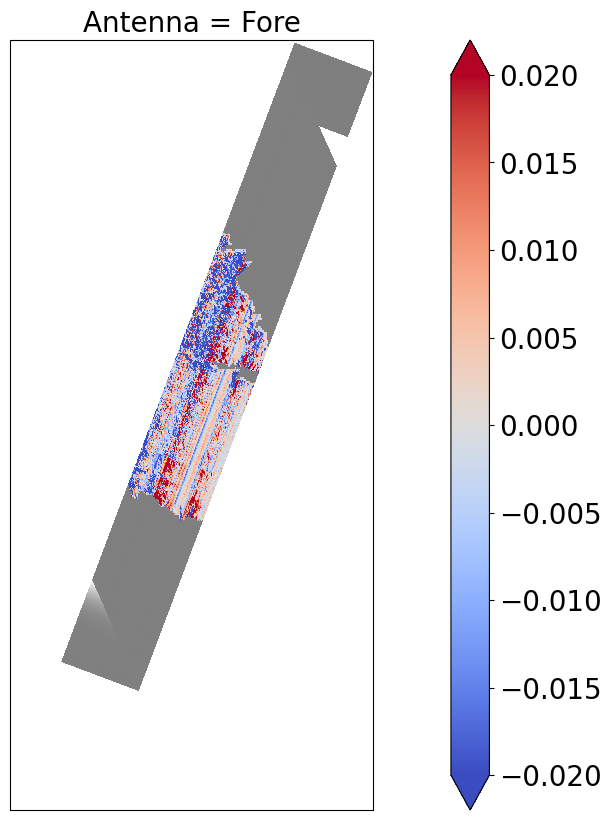

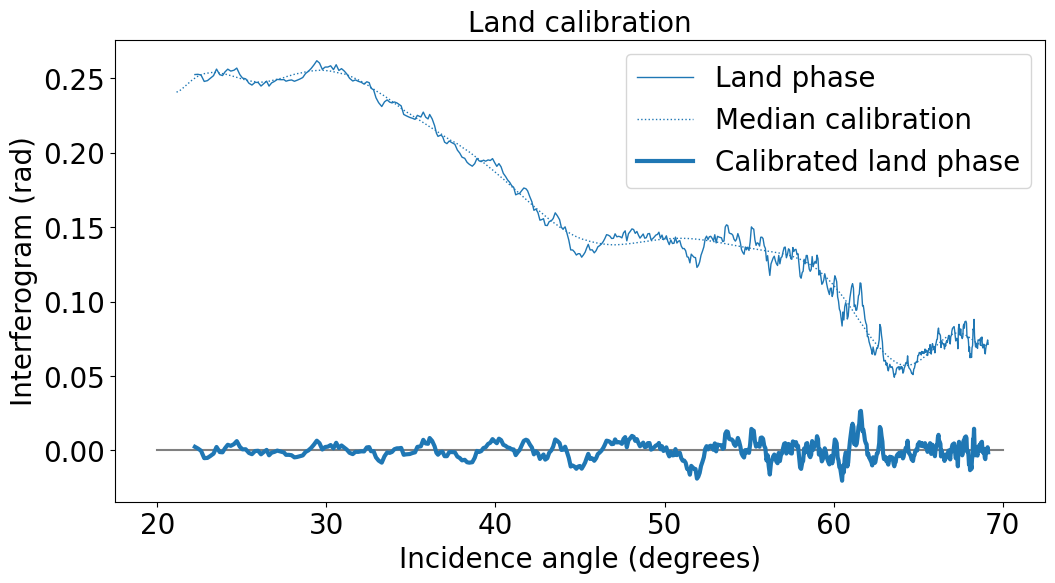

In [33]:
poly_coeff=20
land_track = 'Track_L1'
ds_land_L1b= xr.open_dataset(os.path.join(file_paths['l1b_path'],flight + '_' + land_track + '_OSCAR_L1b.nc'))
I = ds_land_L1b.sel(Antenna='Fore').Interferogram.median(dim='CrossRange')
incidence_angle = ds_land_L1b.sel(Antenna='Fore').IncidenceAngleImage.median(dim='CrossRange').data
valid = ~np.isnan(I)
z = np.polyfit(incidence_angle[valid],
               I[valid].data,
               deg=poly_coeff)
p_fore = np.poly1d(z)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
plt.plot([20,70],[0,0],c=[0.5,0.5,0.5])
plt.plot(incidence_angle, I, c='C0', linewidth=3, label='Land phase')
plt.plot(incidence_angle, p_fore(incidence_angle), c='C0', linewidth=1, label='Polynomial')
plt.title('Land calibration polynomial')
plt.xlabel('Incidence angle (degrees)', fontsize=20)
plt.ylabel('Interferogram (rad)', fontsize=20)
plt.show()

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
(ds_L1b_land\
 .where(ds_L1b_land.LandMask ==1)
 .Interferogram)\
.sel(Antenna='Fore')\
.plot(x='longitude',y='latitude',transform=ccrs.PlateCarree(),ax=ax,vmin=-0.02, vmax=0.02, cmap='coolwarm')
plt.title('Original Interferogram')
ds_L1b_land\
 .where(ds_L1b_land.LandMask ==0)\
.Interferogram\
.sel(Antenna='Fore')\
.plot(x='longitude',y='latitude',transform=ccrs.PlateCarree(),ax=ax,
      cmap='gist_gray',add_colorbar=False)

gl=ax.gridlines(draw_labels=True, color='gray')
gl.top_labels=False
gl.right_labels=False
plt.show()




LC = xr.DataArray(data=p_fore(ds_land_L1b.sel(Antenna='Fore').IncidenceAngleImage.data), 
             coords=ds_land_L1b.Interferogram.sel(Antenna='Fore').coords,
             dims=ds_land_L1b.Interferogram.sel(Antenna='Fore').dims)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im = (I - LC)
im.where(ds_L1b_land.LandMask.sel(Antenna='Fore') == 1)\
.plot(x='longitude',y='latitude',transform=ccrs.PlateCarree(),ax=ax,vmin=-0.02, vmax=0.02, cmap='coolwarm')
plt.title('Calibrated Interferogram using cross-track median polynomial')
im.where(ds_L1b_land.LandMask.sel(Antenna='Fore') == 0)\
.plot(x='longitude',y='latitude',transform=ccrs.PlateCarree(),ax=ax, cmap='gist_gray',add_colorbar=False)


plt.show()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
plt.plot([20,70],[0,0],c=[0.5,0.5,0.5])
plt.plot(incidence_angle, I, c='C0', linewidth=1, label='Land phase')
plt.plot(incidence_angle, LC.median(dim='CrossRange'), c='C0', linewidth=1, linestyle=':', label='Median calibration')

plt.plot(incidence_angle, I - LC.median(dim='CrossRange'), c='C0', linewidth=3, label='Calibrated land phase')
plt.title('Land calibration')
plt.xlabel('Incidence angle (degrees)', fontsize=20)
plt.ylabel('Interferogram (rad)', fontsize=20)
plt.legend()
plt.show()

In [98]:
z = p_fore(ds_ocean_calibrated.IncidenceAngleImage.sel(Antenna=ant).data)
xr.DataArray(data=z, 
             coords=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).coords,
             dims=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).dims)

<xarray.DataArray (CrossRange: 3504, GroundRange: 664)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * GroundRange  (GroundRange) float64 832.0 840.0 848.0 ... 6.128e+03 6.136e+03
  * CrossRange   (CrossRange) float64 -1.4e+04 -1.399e+04 ... 1.402e+04
    Antenna      <U4 'Fore'
    latitude     (CrossRange, GroundRange) float64 ...
    longitude    (CrossRange, GroundRange) float64 ...

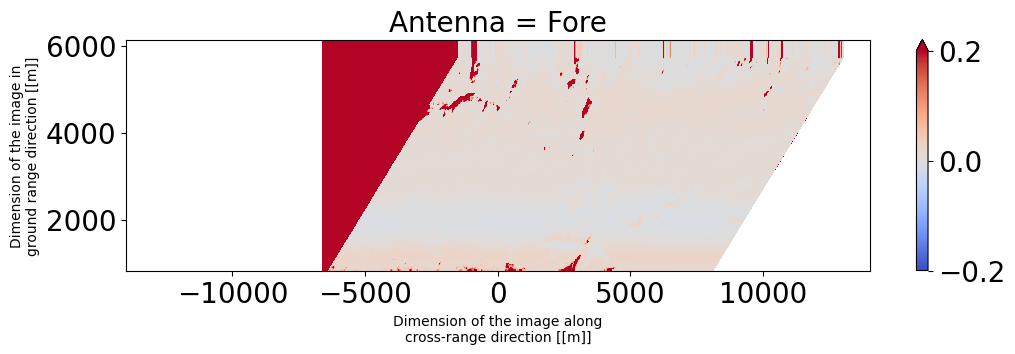

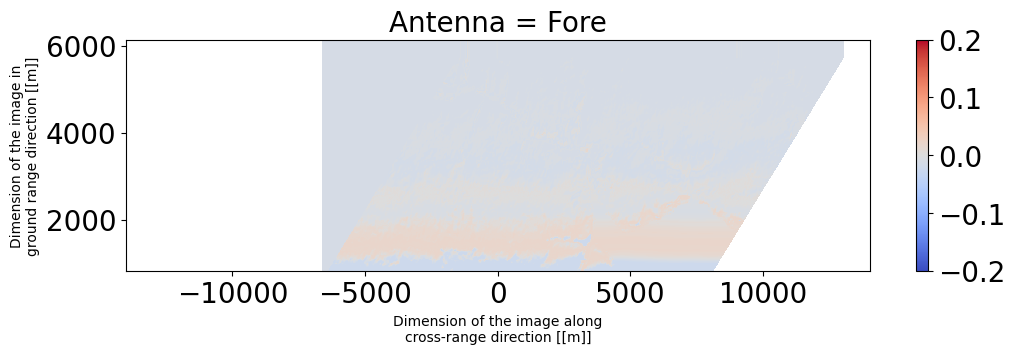

In [112]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
LC = xr.DataArray(data=z, 
             coords=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).coords,
             dims=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).dims)
LC.plot(
    x='CrossRange',y='GroundRange',vmin=-0.2, vmax=0.2, cmap='coolwarm',)
plt.show()

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
SOC = xr.DataArray(data=np.interp(ds_ocean_calibrated.IncidenceAngleImage.sel(Antenna=ant),
                                                         ds_ocean_calib.IncidenceAngle.data,
                                                         ds_ocean_calib.Interferogram.sel(Antenna=ant).data),
                                          coords=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).coords,
                                        dims=ds_ocean_calibrated.Interferogram.sel(Antenna=ant).dims)
SOC.plot(
    x='CrossRange',y='GroundRange',vmin=-0.2, vmax=0.2, cmap='coolwarm',)
plt.show()

In [111]:
LC

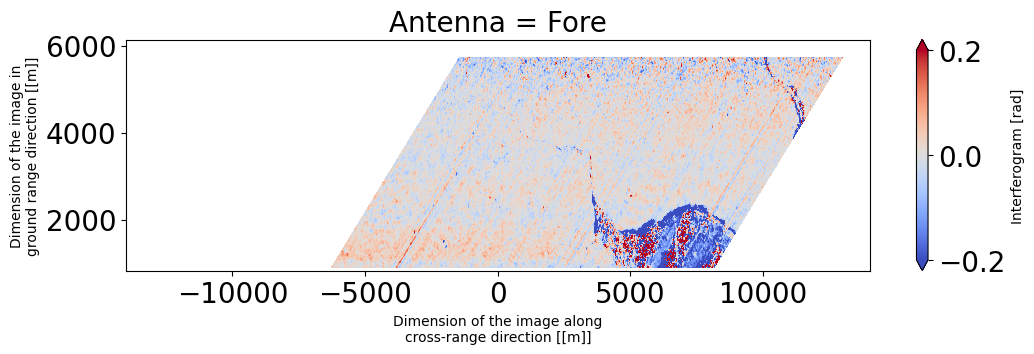

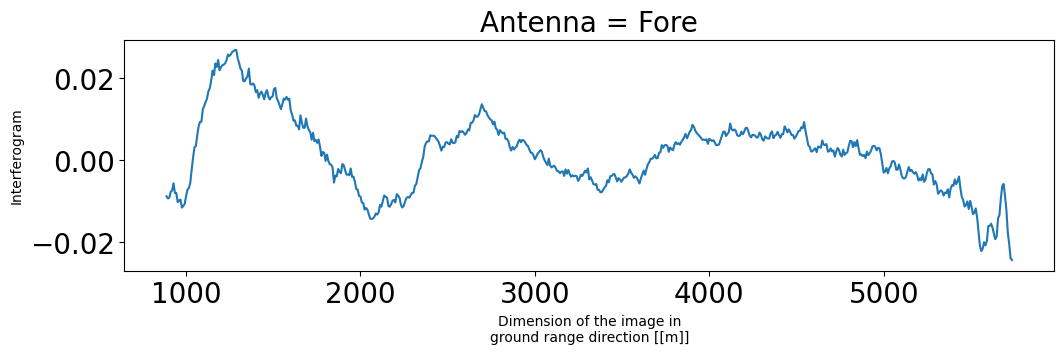

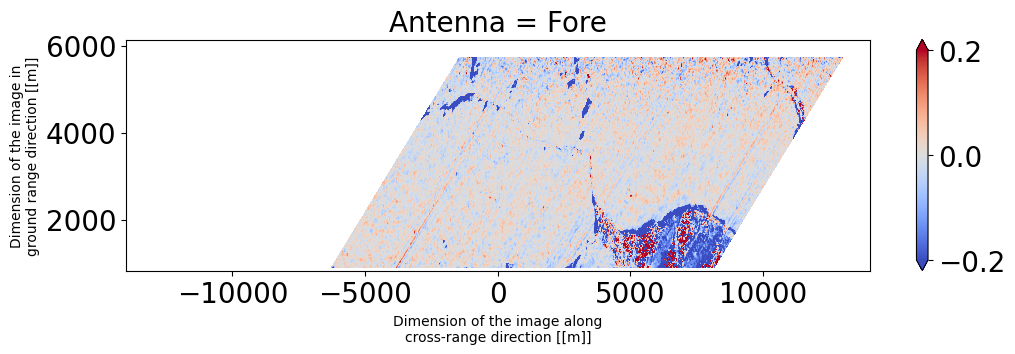

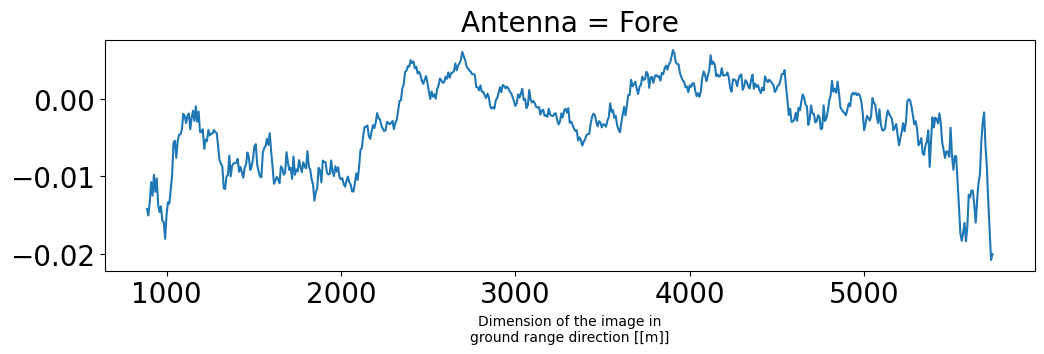

In [116]:
land_track = 'Track_L1'
ds_ocean_calibrated = xr.open_dataset(os.path.join(file_paths['l1b_path'],
                                                              flight + '_' + land_track + '_OSCAR_L1b.nc'))

ant='Fore'
z = p_fore(ds_ocean_calibrated.IncidenceAngleImage.sel(Antenna=ant).data)
da = (ds_ocean_calibrated.Interferogram.sel(Antenna=ant) - SOC) - LC

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
ds_ocean_calibrated.sel(Antenna='Fore').Interferogram.plot(x='CrossRange',y='GroundRange',vmin=-0.2, vmax=0.2, cmap='coolwarm',)
plt.show()
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
ds_ocean_calibrated.sel(Antenna='Fore').Interferogram.median(dim='CrossRange').plot()
plt.show()


fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
da.plot(x='CrossRange',y='GroundRange',vmin=-0.2, vmax=0.2, cmap='coolwarm',)
plt.show()
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1,1,1)
da.median(dim='CrossRange').plot()
plt.show()

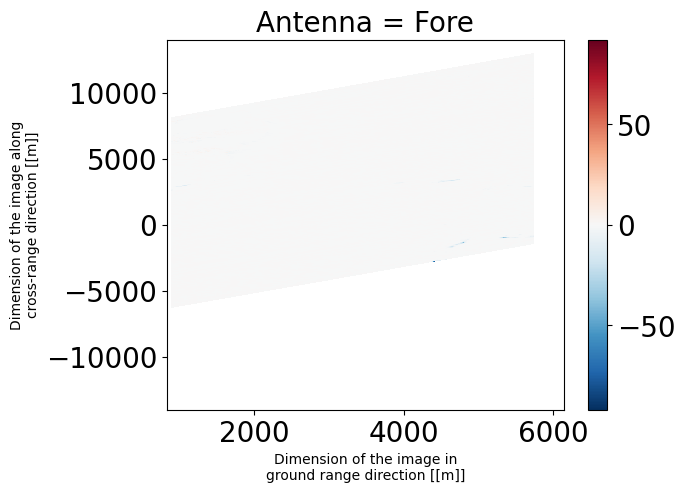

In [101]:
da.plot()

Text(0, 0.5, 'Interferogram fit phase (degrees)')

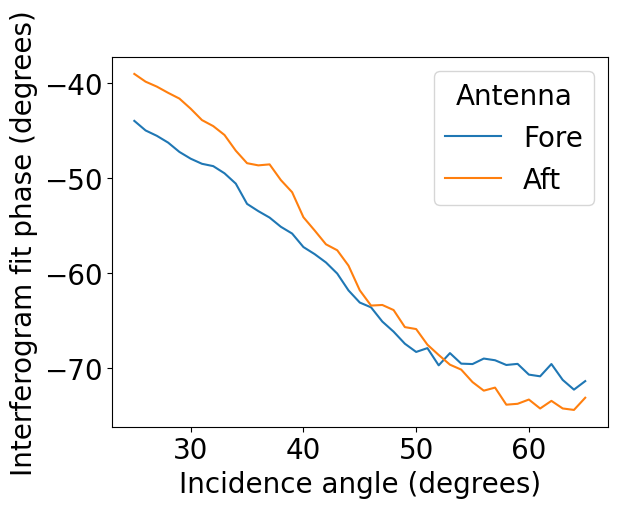

In [66]:
xr.concat([xr.DataArray(
    data=fit.sel(parameters='f', Antenna=['Fore']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                       xr.DataArray(
    data=fit.sel(parameters='f', Antenna=['Aft']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                       xr.DataArray(
    data=fit.sel(parameters='f', Antenna=['Mid']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                      ],pd.Index(['Fore', 'Aft', 'Mid'], name="Antenna"))\
.sel(Antenna=['Fore','Aft'])\
.plot(x='IncidenceAngle',hue='Antenna')
plt.xlabel('Incidence angle (degrees)',fontsize=20)
plt.ylabel('Interferogram fit phase (degrees)',fontsize=20)

In [67]:
fit

<xarray.Dataset>
Dimensions:        (Antenna: 3, inci: 41, parameters: 4)
Coordinates:
  * parameters     (parameters) <U1 'A' 'B' 'C' 'f'
  * inci           (inci) int32 25 26 27 28 29 30 31 32 ... 59 60 61 62 63 64 65
  * Antenna        (Antenna) <U4 'Mid' 'Fore' 'Aft'
Data variables:
    Interferogram  (Antenna, inci, parameters) float64 0.0 0.0 ... -73.16
    Sigma0         (Antenna, inci, parameters) float64 -7.913 0.1139 ... -60.94

In [73]:
ds

<xarray.DataArray 'Interferogram' (inci: 41, parameters: 4)>
array([[-5.06244813e-02,  4.64241170e-01,  4.06348814e-02,
        -4.40110773e+01],
       [-4.58791296e-02,  4.55325424e-01,  3.88868677e-02,
        -4.50199281e+01],
       [-3.50010400e-02,  4.46810551e-01,  3.83516023e-02,
        -4.55860929e+01],
       [-2.58436268e-02,  4.40036329e-01,  3.94163199e-02,
        -4.63003706e+01],
       [-2.07959266e-02,  4.32851308e-01,  3.47918827e-02,
        -4.72800188e+01],
       [-1.40017852e-02,  4.22700136e-01,  4.10515605e-02,
        -4.79925460e+01],
       [-1.04633794e-02,  4.06467709e-01,  4.06759140e-02,
        -4.85291112e+01],
       [-8.00213167e-03,  3.97599596e-01,  4.42470841e-02,
        -4.87751101e+01],
       [-8.15208297e-03,  3.81923706e-01,  5.17510645e-02,
        -4.95296674e+01],
       [-8.90848323e-03,  3.63629397e-01,  5.30722199e-02,
        -5.06160627e+01],
...
       [-1.37990036e-02,  2.80432556e-01,  2.54763244e-02,
        -6.90314061e+01],
       [-1.61606374e-02,  2.83189016e-01,  2.16742444e-02,
        -6.92095237e+01],
       [-1.89697196e-02,  2.85534736e-01,  2.82258639e-02,
        -6.97077227e+01],
       [-2.16435733e-02,  2.87514520e-01,  2.44371975e-02,
        -6.95906466e+01],
       [-1.73570038e-02,  2.85200567e-01,  2.18045475e-02,
        -7.07215577e+01],
       [-1.43419496e-02,  2.84428499e-01,  2.77423496e-02,
        -7.09006232e+01],
       [-1.20680671e-02,  2.90423416e-01,  2.76693060e-02,
        -6.96065269e+01],
       [-1.02314350e-02,  2.91660977e-01,  2.13044628e-02,
        -7.12773668e+01],
       [-9.81601369e-03,  2.90755851e-01,  1.86962856e-02,
        -7.23027814e+01],
       [-1.02059137e-02,  3.04925363e-01,  1.79919642e-02,
        -7.14052349e+01]])
Coordinates:
  * parameters  (parameters) <U1 'A' 'B' 'C' 'f'
  * inci        (inci) int32 25 26 27 28 29 30 31 32 ... 58 59 60 61 62 63 64 65
    Antenna     <U4 'Fore'

In [ ]:
(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value)[var_to_plot + '_popt'].data),
                 'blue', label='Aft')

In [166]:
def OSM_func(az, A, B, C, f):
    osm = A + B * np.cos(np.radians(az - f))\
    + C * np.cos(np.radians(2 * az - f))
    return osm.ravel()
def WASV_func(az, A, B, C, f):
    fw = -40
    wasv = A + B * np.cos(np.radians(az - fw))\
    + C * np.cos(np.radians(2 * az - fw))
    return wasv.ravel()
def C_func(inc, A, fc):
    current = A * np.sin(np.radians(inc - fc))
    return current.ravel()

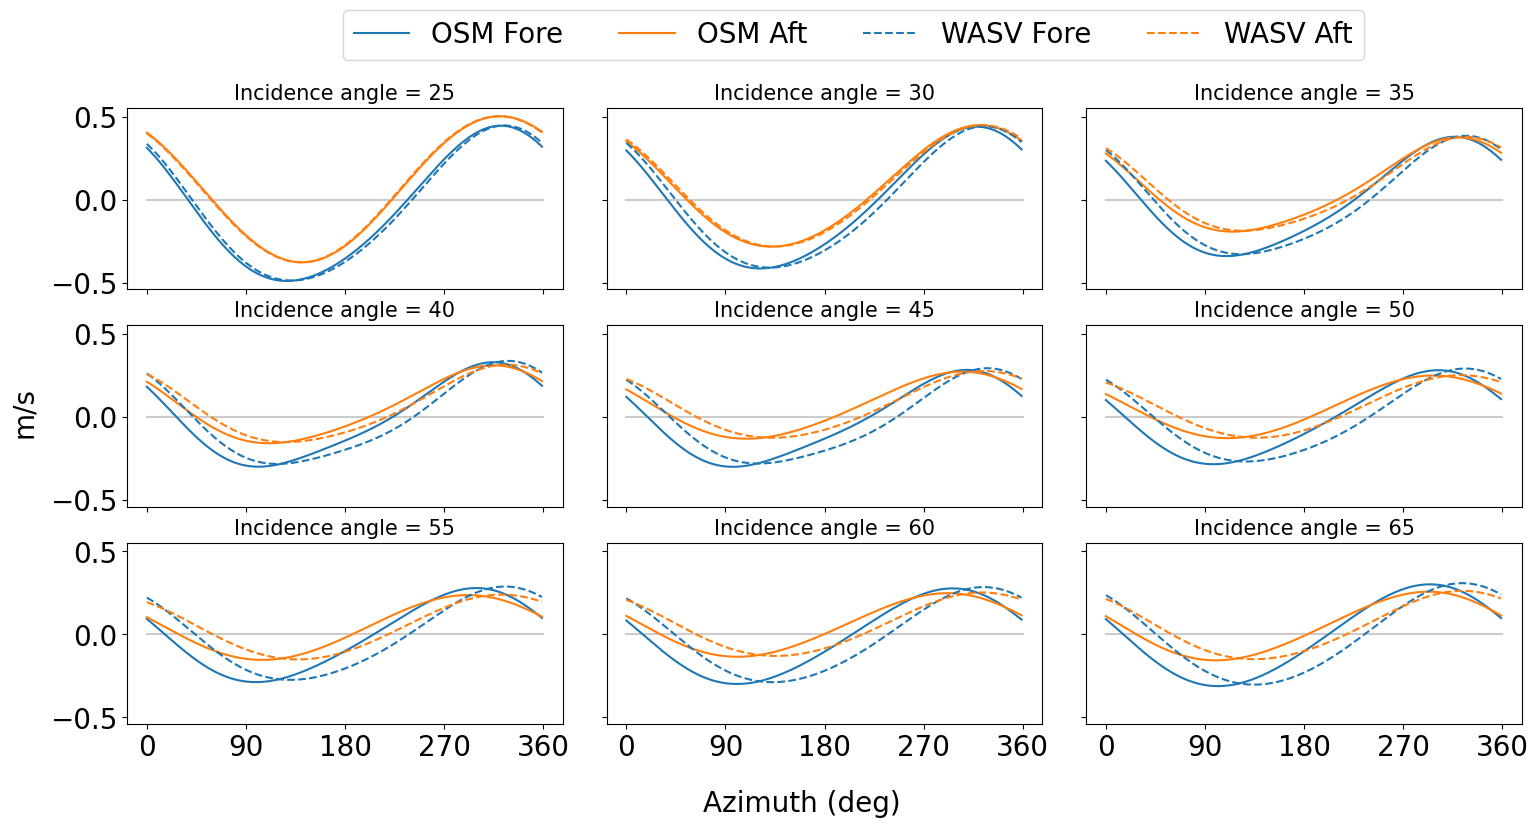

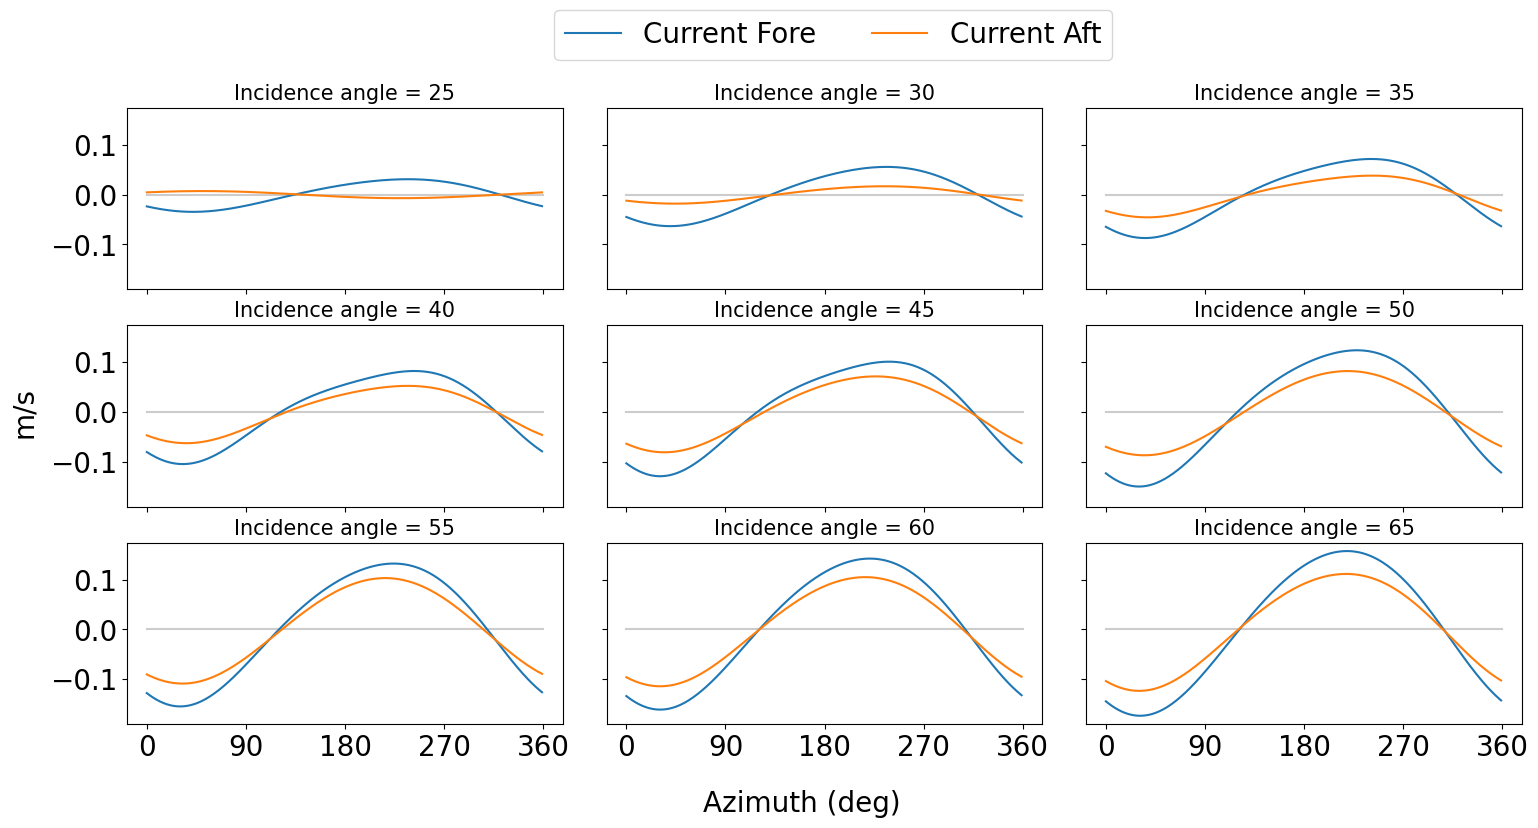

In [163]:
ds = fit.Interferogram.sel(Antenna='Fore')
az = np.arange(0,360)
ones = np.ones(np.size(az))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True,
                        sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
for ii, inci_value in enumerate(np.arange(25,66,5)):
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, OSM_func(az, *fit.sel(Antenna='Fore', inci=inci_value)['Interferogram'].data),
                 'C0', label='OSM Fore')
    axs[ii].plot(az, OSM_func(az, *fit.sel(Antenna='Aft', inci=inci_value)['Interferogram'].data),
                 'C1', label='OSM Aft')
    
    axs[ii].plot(az, WASV_func(az, *fit.sel(Antenna='Fore', inci=inci_value)['Interferogram'].data),
                 'C0', linestyle='--', label='WASV Fore')
    axs[ii].plot(az, WASV_func(az, *fit.sel(Antenna='Aft', inci=inci_value)['Interferogram'].data),
                 'C1', linestyle='--', label='WASV Aft')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])          
fig.text(0.5, 0, 'Azimuth (deg)', ha='center')
fig.text(0.06, 0.5, 'm/s', va='center', rotation='vertical')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,bbox_to_anchor=(0.82,1.02))
plt.show()

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True,
                        sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
for ii, inci_value in enumerate(np.arange(25,66,5)):
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, OSM_func(az, *fit.sel(Antenna='Fore', inci=inci_value)['Interferogram'].data)
                 - WASV_func(az, *fit.sel(Antenna='Fore', inci=inci_value)['Interferogram'].data),
                 'C0', label='Current Fore')
    axs[ii].plot(az, OSM_func(az, *fit.sel(Antenna='Aft', inci=inci_value)['Interferogram'].data)
                 - WASV_func(az, *fit.sel(Antenna='Aft', inci=inci_value)['Interferogram'].data),
                 'C1', label='Current Aft')
    
    
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])          
fig.text(0.5, 0, 'Azimuth (deg)', ha='center')
fig.text(0.06, 0.5, 'm/s', va='center', rotation='vertical')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.68,1.02))
plt.show()


In [140]:
# inci_joint = np.arange(25,66,0.5)
az = np.arange(0,360)
nb_parameters = 4
current_popt = np.zeros( (fit.Antenna.size, len(fit.inci.data), nb_parameters) )
for iantenna, antenna in enumerate(fit.Antenna.data):
    for ii, inci_value in enumerate(fit.inci.data):
        current = OSM_func(az, *fit.sel(Antenna=antenna, inci=inci_value)['Interferogram'].data)\
                 - WASV_func(az, *fit.sel(Antenna=antenna, inci=inci_value)['Interferogram'].data)
        current_popt[iantenna, ii, :], pcov = curve_fit(OSM_func, az,  current)
fit_current = xr.Dataset({"current_popt": (["Antenna", "inci", "parameters"], current_popt)},
                 coords={"parameters": (["parameters"], ["A", "B", "C", "f"]),
                         "inci": (["inci"], fit.inci.data),
                         "Antenna": (["Antenna"], fit.Antenna.data)})

C:\Users\dmca\AppData\Local\anaconda3\envs\seastar\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [132]:
fit.inci

<xarray.DataArray 'inci' (inci: 41)>
array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65])
Coordinates:
  * inci     (inci) int32 25 26 27 28 29 30 31 32 33 ... 58 59 60 61 62 63 64 65

[ 1.38279713e-11 -1.35317351e-01 -1.65038050e-02  3.58327385e+01]


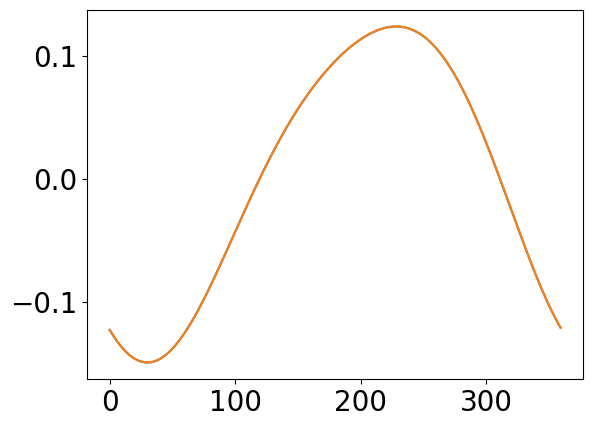

In [131]:
inci_value=50
antenna='Fore'
current = OSM_func(az, *fit.sel(Antenna=antenna, inci=inci_value)['Interferogram'].data)\
                 - WASV_func(az, *fit.sel(Antenna=antenna, inci=inci_value)['Interferogram'].data)
plt.plot(az, current)
popt, pcov = curve_fit(OSM_func, az,  current)
plt.plot(az, OSM_func(az, *popt))
print(popt)

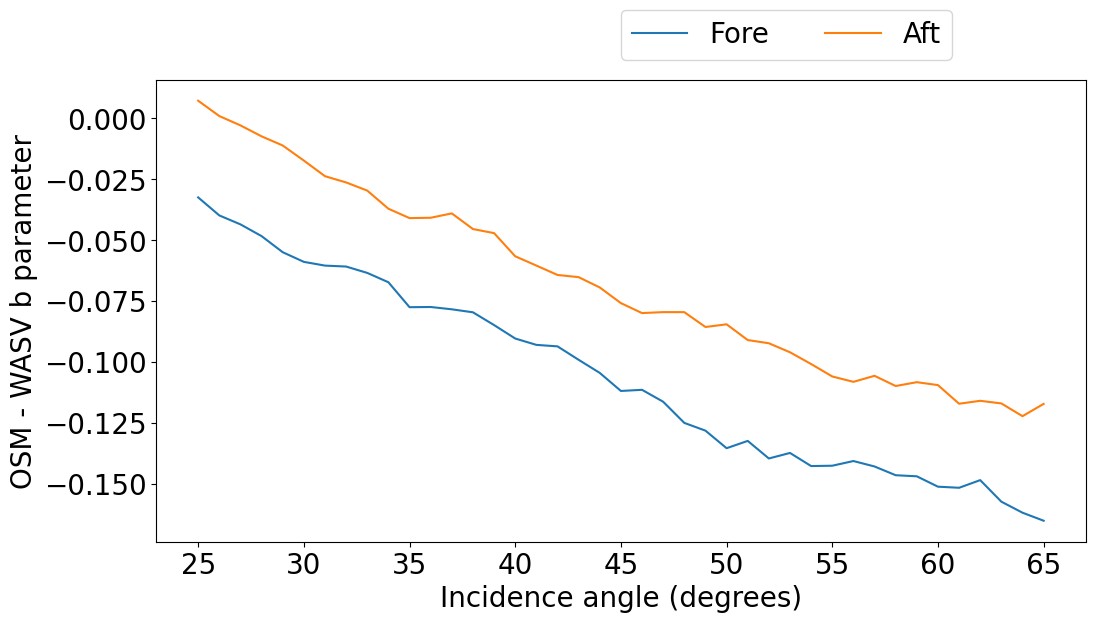

In [164]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
plt.plot(fit_current.inci.data, fit_current.sel(parameters='B', Antenna='Fore').current_popt,c='C0', label='Fore')
plt.plot(fit_current.inci.data, fit_current.sel(parameters='B', Antenna='Aft').current_popt, c='C1', label='Aft')
# plt.plot(fit_current.inci.data, -0.15 * np.sin(np.radians(fit_current.inci.data)), c='k', label='-0.15 * sin(theta)')
plt.xlabel('Incidence angle (degrees)', fontsize=20)
plt.ylabel('OSM - WASV b parameter', fontsize=20)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3,bbox_to_anchor=(0.8,1.02))
plt.show()

In [27]:
import hashlib

In [35]:
def file_short_name_from_md5(file_name):
    md5_checksum = hashlib.md5(open(os.path.join(file_name),'rb').read()).hexdigest()
    calib_file_short_name = md5_checksum[0:4]
    return calib_file_short_name

'85ac'